# DoorDash Challenge Project

# Part 1: EDA

# Applicant: Yu-Ting Shen

## Table of Contents

* [Data description](#Data-Description)
* [Load data](#Load-data)
* [Exploratory data analysis](#Exploratory-data-analysis)
* [Feature engeering](#Feature-engeering)
* [Model building](#Model-building)

# Data Description


* After reading the data description, I summary some important parts:
  * Money: in **cents**
  * time duration in **seconds**
  * The goal is to predict the time between `created_at` and `actual_delivery_time` in seconds
    * I will define `duration` = `actual_delivery_time` - `created_at` in seconds
  * There are noises in the datasets, so I have to clean the data

In [1]:
with open("data_description.txt") as fin:
    descriptions = fin.readlines()
    
for line in descriptions:
    print(line)

#### Data description #### 

The attached file `historical_data.csv` contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds 

The target value to predict here is the total seconds value between `created_at` and `actual_delivery_time`. 



We have added noise to the dataset to obfuscate certain business details. Both `historical_data.csv` and `predict_data.csv` include similar noise. We will only be evaluating your model's performance on this noisy, artificial dataset. The baseline model we will compare it was also trained and evaluated on the same noisy dataset.



#### Columns in historical_data.csv



### Time features

market_id: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id

crea

# Import packages

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

# Load data

* Given `historical_data.csv` for training and `predict_data.csv` for making prediction.
* The first step is loading the datasets into the Pandas dataframe and check how the data look like.

In [3]:
# Load historical_data.csv for training
df_train = pd.read_csv("historical_data.csv")
display(df_train.head())
display(df_train.info())

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900,1.0,2.0,2.0,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900,1.0,0.0,0.0,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,6900,1.0,1.0,2.0,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,3900,6.0,6.0,9.0,650.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 9 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   subtotal                                      197428 non-null  int64  
 5   total_onshift_dashers                         181166 non-null  float64
 6   total_busy_dashers                            181166 non-null  float64
 7   total_outstanding_orders                      181166 non-null  float64
 8   estimated_store_to_consumer_driving_duration  196902 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 

None

In [4]:
cols = df_train.columns.difference(["market_id", "store_id", "created_at", "actual_delivery_time"])
df_train.loc[:, cols].describe()

,estimated_store_to_consumer_driving_duration,subtotal,total_busy_dashers,total_onshift_dashers,total_outstanding_orders
count,196902.000000,197428.000000,181166.000000,181166.000000,181166.000000
mean,545.358935,2682.331402,41.739747,44.808093,58.050065
std,219.352902,1823.093688,32.145733,34.526783,52.661830
min,0.000000,0.000000,-5.000000,-4.000000,-6.000000
25%,382.000000,1400.000000,15.000000,17.000000,17.000000
50%,544.000000,2200.000000,34.000000,37.000000,41.000000
75%,702.000000,3395.000000,62.000000,65.000000,85.000000
max,2088.000000,27100.000000,154.000000,171.000000,285.000000


In [5]:
# check number of unique market_id
print(f"Number of market_id = {df_train['market_id'].nunique()}")

# check number of unique store_id
print(f"Number of market_id = {df_train['store_id'].nunique()}")

Number of market_id = 6
Number of market_id = 6743


In [6]:
# count missing values
df_train.isnull().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
subtotal                                            0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [7]:
# Load predict_data.csv for testing
df_test = pd.read_csv("predict_data.csv")
display(df_test.head())
display(df_test.info())

,market_id,created_at,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id
0,3.0,2015-02-25 02:22:30,5477,7500,4.0,4.0,4.0,670.0,194096
1,3.0,2015-02-25 01:14:19,5477,7100,4.0,1.0,1.0,446.0,236895
2,4.0,2015-02-22 02:27:44,5477,4500,9.0,7.0,6.0,504.0,190868
3,3.0,2015-02-25 01:32:39,5477,1700,3.0,3.0,3.0,687.0,183076
4,1.0,2015-02-24 05:20:45,2841,3150,4.0,4.0,4.0,528.0,186200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54778 entries, 0 to 54777
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   market_id                                     54528 non-null  float64
 1   created_at                                    54778 non-null  object 
 2   store_id                                      54778 non-null  int64  
 3   subtotal                                      54778 non-null  int64  
 4   total_onshift_dashers                         50145 non-null  float64
 5   total_busy_dashers                            50145 non-null  float64
 6   total_outstanding_orders                      50145 non-null  float64
 7   estimated_store_to_consumer_driving_duration  54767 non-null  float64
 8   delivery_id                                   54778 non-null  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 3.8+ MB


None

In [8]:
cols = df_test.columns.difference(["market_id", "store_id", "created_at", "actual_delivery_time"])
df_test.loc[:, cols].describe()

,delivery_id,estimated_store_to_consumer_driving_duration,subtotal,total_busy_dashers,total_onshift_dashers,total_outstanding_orders
count,54778.000000,54767.000000,54778.000000,50145.000000,50145.000000,50145.000000
mean,126118.103454,547.765406,2715.758772,43.515206,49.076179,62.566756
std,72683.611935,220.459715,1897.919808,34.051339,37.594714,56.378953
min,20.000000,0.000000,0.000000,-4.000000,-1.000000,-9.000000
25%,62938.500000,385.000000,1420.000000,16.000000,19.000000,19.000000
50%,126194.000000,544.000000,2220.000000,36.000000,41.000000,45.000000
75%,188916.000000,703.000000,3415.000000,63.000000,71.000000,91.000000
max,252031.000000,1550.000000,29925.000000,169.000000,175.000000,292.000000


In [9]:
# check number of unique market_id
print(f"Number of market_id = {df_test['market_id'].nunique()}")

# check number of unique store_id
print(f"Number of market_id = {df_test['store_id'].nunique()}")

Number of market_id = 6
Number of market_id = 5676


In [10]:
df_test.isnull().sum()

market_id                                        250
created_at                                         0
store_id                                           0
subtotal                                           0
total_onshift_dashers                           4633
total_busy_dashers                              4633
total_outstanding_orders                        4633
estimated_store_to_consumer_driving_duration      11
delivery_id                                        0
dtype: int64

From the above information, I notice that
* The `market_id` and `store_id` should convert into **categorical** data format
* The `created_at` and `actual_delivery_time` should convert into **datetime** format
* The following columns have missing values:
  * `market_id`
  * `actual_delivery_time`
  * `total_onshift_dashers`
  * `total_busy_dashers`
  * `total_outstanding_orders`
  *`estimated_store_to_consumer_driving_duration`
* There are negative values in the following columns, which is unreasonable.
  * `total_onshift_dashers`, 
  * `total_busy_dashers`,
  * `total_outstanding_orders`
* The `total_busy_dashers` > `total_onshift_dashers` in some rows, which is unreasonable.

# Exploratory data analysis

### Convert data type and create new features

* Convert `created_at` and `actual_delivery_time` into datetime format
* Convert `market_id` and `store_id` into category
* Create new features:
  * duration = `actual_delivery_time` - `created_at` in second
  * extract month, week, dayofweek, and hour information from `created_at`

In [11]:
def convert_data_type(df):
    for col in df.columns:
        if col in ["market_id", "store_id"]:
            df[col] = df[col].astype("category")
        if col in ["created_at", "actual_delivery_time"]:
            df[col] = pd.to_datetime(df[col], infer_datetime_format=True)
    return df

def create_new_features(df):
    # create duration which is the time difference between
    # actual_delivery_time and created_at in seconds
    df["duration"] = (df["actual_delivery_time"] - df["created_at"]) / np.timedelta64(1, 's')
    
    # extract month, week, dayofweek and hours from created_at
    df["month"] = df["created_at"].dt.month
    df["week"] = df["created_at"].dt.isocalendar().week
    df["dayofweek"] = df["created_at"].dt.dayofweek
    df["hour"] = df["created_at"].dt.hour
    
    return df

In [12]:
df_train = convert_data_type(df_train)
df_train = create_new_features(df_train)

In [13]:
# checker the min and max timestamp
print(f"Minimum of created_at = {df_train['created_at'].min()}")
print(f"Maximum of created_at = {df_train['created_at'].max()}")
print("\n")
print(f"Minimum of actual_delivery_time = {df_train['actual_delivery_time'].min()}")
print(f"Maximum of actual_delivery_time = {df_train['actual_delivery_time'].max()}")

Minimum of created_at = 2014-10-19 05:24:15
Maximum of created_at = 2015-02-18 06:00:44


Minimum of actual_delivery_time = 2015-01-21 15:58:11
Maximum of actual_delivery_time = 2015-02-19 22:45:31


The minimum created_at is 2014-10-19 05:24:15 but the minimum actual_delivery_time is 2015-01-21 15:58:11. It took 3 months to deliver. There should be something wrong. Let me should check the create_date < 2015-01-01

In [14]:
df_train.loc[df_train["created_at"]<"2015-01-01"]

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,duration,month,week,dayofweek,hour
2690,1.0,2014-10-19 05:24:15,2015-01-25 19:11:54,3560,1695,NaN,NaN,NaN,412.0,8516859.0,10,42,6,5


Because there is only one row with created_at < 2015-01-01, we can delete this row

In [15]:
df_train = df_train.loc[df_train["created_at"]>="2015-01-01"]

### Fix the data issue and apply missing value imputation

* There are some rows where total_onshift_dashers, total_busy_dashers, or total_outstanding_orders are negative. I consider to use the absolute values for these rows.
* There are some rows where total_busy_dashers > total_onshift_dashers. I force the total_onshift_dashers equals to total_busy_dashers
* There are many rows where total_onshift_dashers, total_busy_dashers, or total_outstanding_orders are missing. 
  * I fill the missing values using same market and same created_at hour.
  * If there are minissing values, then I fill the missing value using same store and same created_at hour
  * If there are minissing values, then I fill the missing value using same created_at hour

In [16]:
# Check number of rows where the column value < 0
print(len(df_train[df_train["total_onshift_dashers"] < 0]))
print(len(df_train[df_train["total_busy_dashers"] < 0]))
print(len(df_train[df_train["total_outstanding_orders"] < 0]))

# Check number of rows where total_busy_dashers > total_onshift_dashers
print(len(df_train[df_train["total_busy_dashers"] > df_train["total_onshift_dashers"]]))

21
21
44
40394


In [17]:
# use absolute value for negative value
for col_name in ["total_onshift_dashers", "total_busy_dashers", "total_outstanding_orders"]:
    df_train[col_name] = abs(df_train[col_name])

# force total_onshift_dashers >= total_busy_dashers
df_train["total_onshift_dashers"] = df_train.apply(
    lambda row:
    row["total_onshift_dashers"]
    if row["total_onshift_dashers"] >= row["total_busy_dashers"]
    else row["total_busy_dashers"],
    axis=1
)

# fill the missing values 
for col_name in ["total_onshift_dashers", "total_busy_dashers", "total_outstanding_orders"]:
    # groupby same market and same created hour    
    df_train[col_name] = (
        df_train.groupby(["market_id", "hour"])[col_name].transform(
            lambda x: x.fillna(x.mean())
        )
    )
    
    # groupby same store and same created hour 
    df_train[col_name] = (
        df_train.groupby(["store_id", "hour"])[col_name].transform(
            lambda x: x.fillna(x.mean())
        )
    )
    
    # groupby same created hour
    df_train[col_name] = (
        df_train.groupby(["hour"])[col_name].transform(
            lambda x: x.fillna(x.mean())
        )
    )

In [18]:
df_train.isnull().sum()

market_id                                       987
created_at                                        0
actual_delivery_time                              7
store_id                                          0
subtotal                                          0
total_onshift_dashers                             0
total_busy_dashers                                0
total_outstanding_orders                          0
estimated_store_to_consumer_driving_duration    526
duration                                          7
month                                             0
week                                              0
dayofweek                                         0
hour                                              0
dtype: int64

There are 526 missing values in estimated_store_to_consumer_driving_duration. 
* I fill the missing value using same store and same created_at hour
* If there are minissing values, then I fill the missing value using same created_at hour

In [19]:
# fill the missing values using same store and same created hour
df_train["estimated_store_to_consumer_driving_duration"] = (
    df_train.groupby(["store_id", "hour"])["estimated_store_to_consumer_driving_duration"].transform(
        lambda x: x.fillna(x.mean())
    )
)

# fill the missing values using same store and same created hour
df_train["estimated_store_to_consumer_driving_duration"] = (
    df_train.groupby(["hour"])["estimated_store_to_consumer_driving_duration"].transform(
        lambda x: x.fillna(x.mean())
    )
)

In [20]:
df_train.isnull().sum()

market_id                                       987
created_at                                        0
actual_delivery_time                              7
store_id                                          0
subtotal                                          0
total_onshift_dashers                             0
total_busy_dashers                                0
total_outstanding_orders                          0
estimated_store_to_consumer_driving_duration      0
duration                                          7
month                                             0
week                                              0
dayofweek                                         0
hour                                              0
dtype: int64

There are 7 rows without actual_delivery_time causing the missing value in duration. I drop these rows

In [21]:
df_train = df_train.loc[df_train["actual_delivery_time"].notnull()]
df_train.shape

(197420, 14)

### Add new mean and std as new features

Now I group market_id, store_id, month, week, dayofweek, hour one at a time to calculate the duration mean and std

In [22]:
# calculate duration mean for different granularity
def calculate_duration_mean(groupby_col_name, new_col_name):
    df_groupby = (
        df_train.groupby(groupby_col_name)[["duration"]]
        .mean().reset_index()
        .rename(columns={"duration": new_col_name})
    )
    return df_groupby

df_duration_mean_market = calculate_duration_mean("market_id", "dt_market")
df_duration_mean_store = calculate_duration_mean("store_id", "dt_store")
df_duration_mean_month = calculate_duration_mean("month", "dt_month")
df_duration_mean_week = calculate_duration_mean("week", "dt_week")
df_duration_mean_dayofweek = calculate_duration_mean("dayofweek", "dt_dayofweek")
df_duration_mean_hour = calculate_duration_mean("hour", "dt_hour")

# calculate std for different granularity
def calculate_duration_std(groupby_col_name, new_col_name):
    df_groupby = (
        df_train.groupby(groupby_col_name)[["duration"]]
        .std().reset_index()
        .rename(columns={"duration": new_col_name})
    )
    return df_groupby

df_duration_std_market = calculate_duration_std("market_id", "sdt_market")
df_duration_std_store = calculate_duration_std("store_id", "sdt_store")
df_duration_std_month = calculate_duration_std("month", "sdt_month")
df_duration_std_week = calculate_duration_std("week", "sdt_week")
df_duration_std_dayofweek = calculate_duration_std("dayofweek", "sdt_dayofweek")
df_duration_std_hour = calculate_duration_std("hour", "sdt_hour")


Now I merge these information into df_train to get new features

In [23]:
list_of_dfs = [
    df_duration_mean_market, 
    df_duration_mean_store,
    df_duration_mean_month,
    df_duration_mean_week,
    df_duration_mean_dayofweek,
    df_duration_mean_hour,
    df_duration_std_market,
    df_duration_std_store,
    df_duration_std_month,
    df_duration_std_week,
    df_duration_std_dayofweek,
    df_duration_std_hour
]
    
for df_i in list_of_dfs:
    col_name = df_i.columns[0]
    df_train = df_train.merge(df_i, on=col_name)
    
df_train.isnull().sum()

market_id                                         0
created_at                                        0
actual_delivery_time                              0
store_id                                          0
subtotal                                          0
total_onshift_dashers                             0
total_busy_dashers                                0
total_outstanding_orders                          0
estimated_store_to_consumer_driving_duration      0
duration                                          0
month                                             0
week                                              0
dayofweek                                         0
hour                                              0
dt_market                                         0
dt_store                                          0
dt_month                                          0
dt_week                                           0
dt_dayofweek                                      0
dt_hour     

There are 563 std_store haveing NaN, which mean these stores only have one records in the data. Therefore, I decide to drop these rows

In [24]:
df_train = df_train.dropna(how="any")
df_train.shape

(195870, 26)

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195870 entries, 1 to 196432
Data columns (total 26 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     195870 non-null  category      
 1   created_at                                    195870 non-null  datetime64[ns]
 2   actual_delivery_time                          195870 non-null  datetime64[ns]
 3   store_id                                      195870 non-null  category      
 4   subtotal                                      195870 non-null  int64         
 5   total_onshift_dashers                         195870 non-null  float64       
 6   total_busy_dashers                            195870 non-null  float64       
 7   total_outstanding_orders                      195870 non-null  float64       
 8   estimated_store_to_consumer_driving_duration  195870 n

### Simple data analysis
I generated new features and applied missing valuation imputations. It is time to do some analysis
* count number of orders in the following granularity: market_id, store_id, month, week, dayofweek, hour

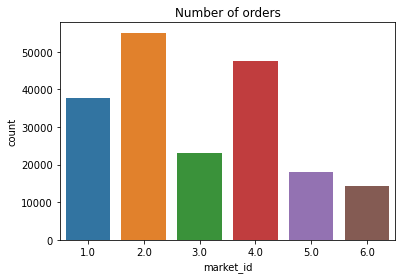

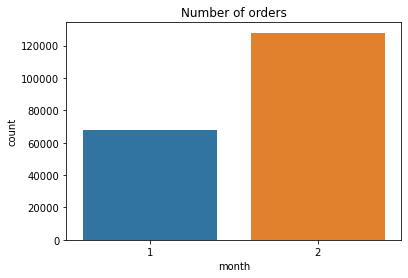

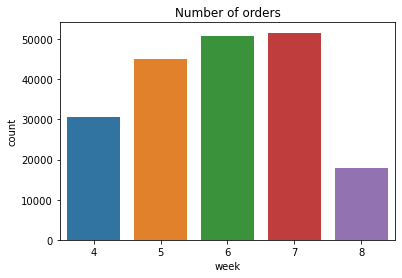

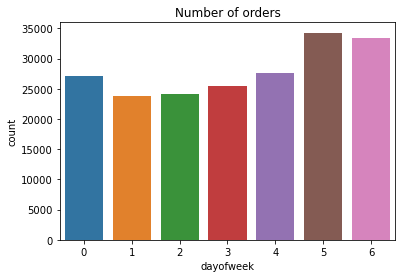

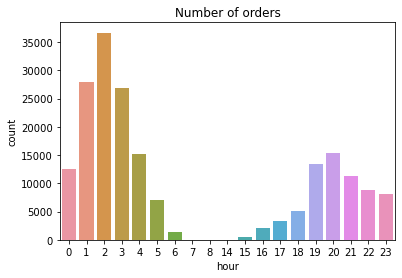

In [26]:
def plot_count(df, col_name):
    df_sub = df[col_name].value_counts().to_frame().reset_index()
    df_sub.columns = [col_name, "count"]
    
    fig, ax = plt.subplots()
    sns.barplot(df_sub[col_name],df_sub["count"])
    ax.set_xlabel(col_name)
    ax.set_ylabel("count")
    ax.set_title("Number of orders")
    plt.show()

for col_name in ["market_id", "month", "week", "dayofweek", "hour"]:
    plot_count(df_train, col_name)

I find:
* Market 2 & 4 have the most orders
* Orders in February is more than January.
* The 5th, 6th, 7th week of the year have more order
* More orders in weekend than weekday.
* The orders can be divided into 3 windows: (0, 5), (6, 17), (18, 23)

* Check the distribution for continuous variables

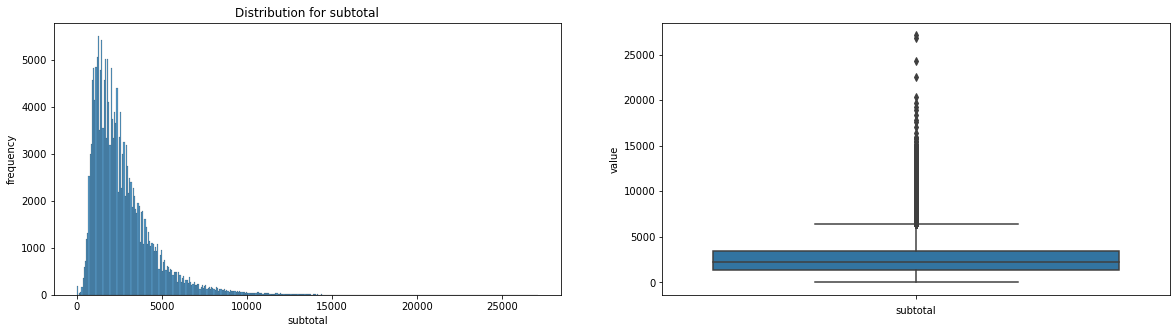

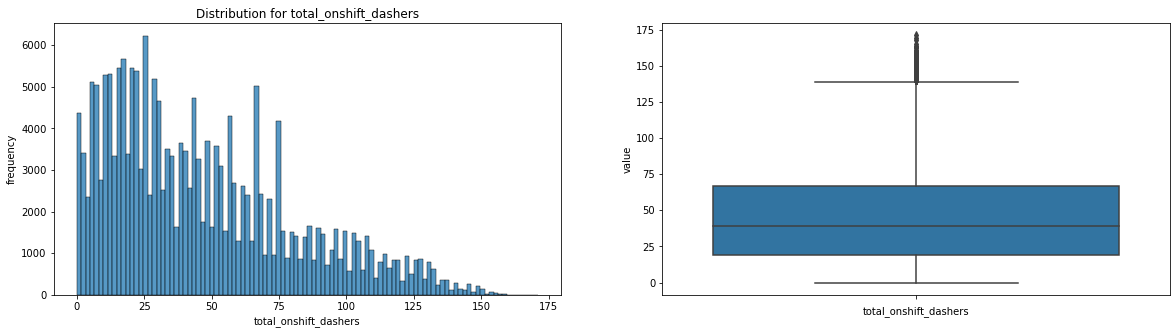

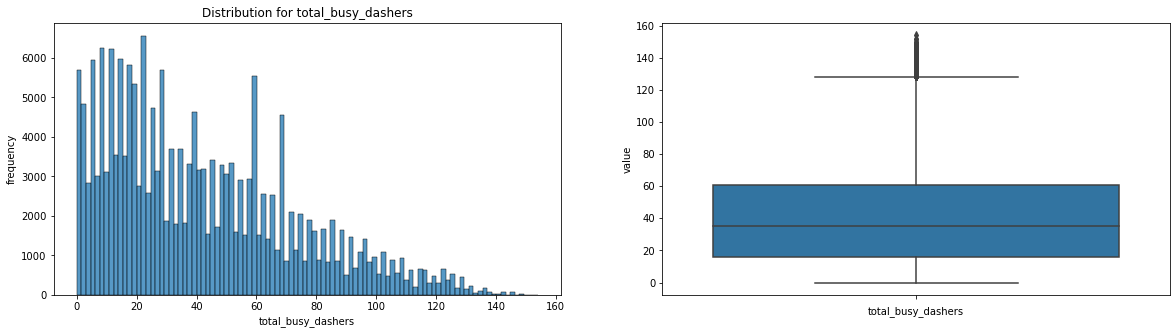

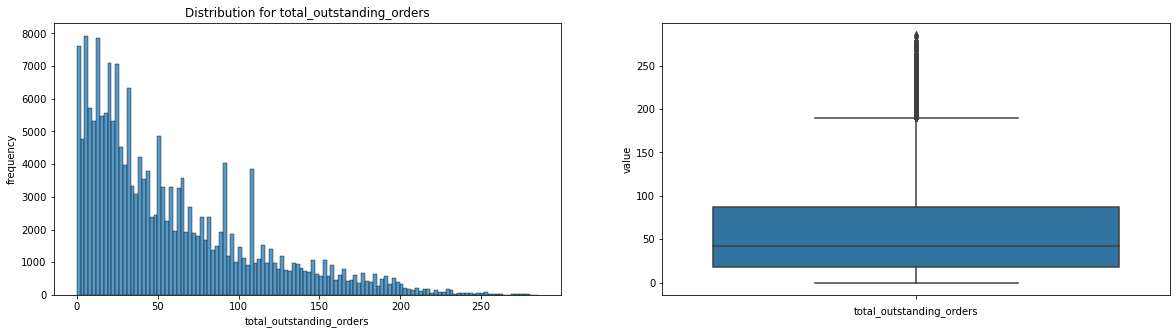

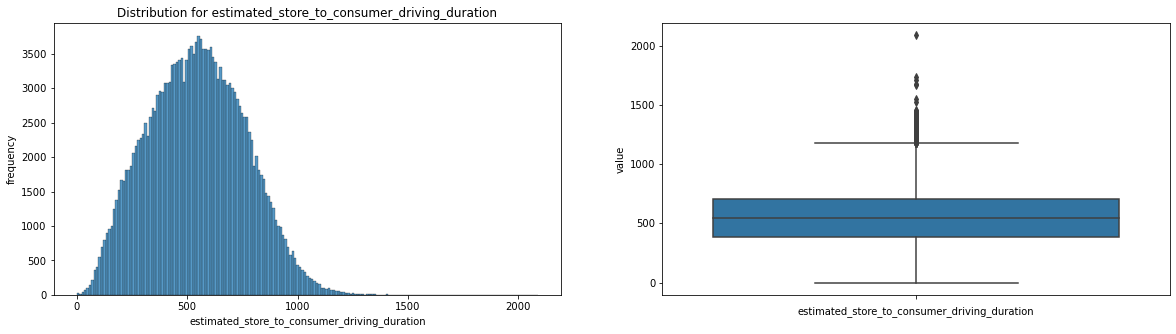

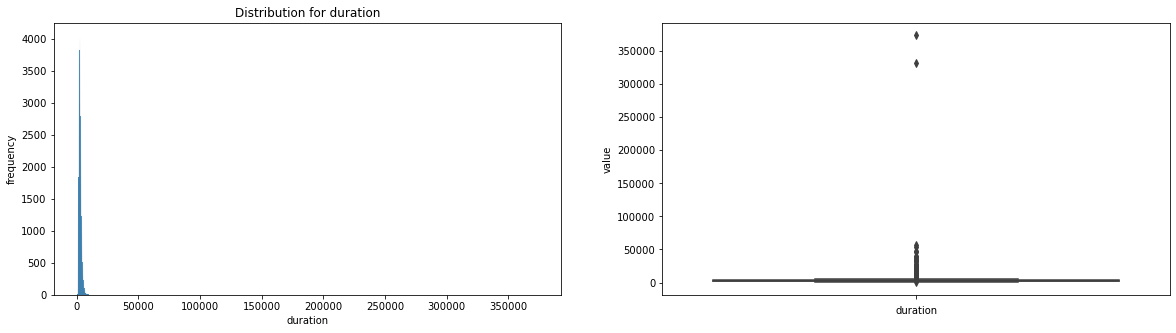

In [27]:
def plot_distribution(df, col_name):
    df_sub = df.loc[:,[col_name]]
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    sns.histplot(data=df_sub, x=col_name, ax=ax[0])
    ax[0].set_xlabel(col_name)
    ax[0].set_ylabel("frequency")
    ax[0].set_title(f"Distribution for {col_name}")
    
    sns.boxplot(data=df_sub, y=col_name, ax=ax[1])
    ax[1].set_xlabel(col_name)
    ax[1].set_ylabel("value")

    plt.show()
    
continuous_columns = [
    "subtotal",
    "total_onshift_dashers",
    "total_busy_dashers",
    "total_outstanding_orders",
    "estimated_store_to_consumer_driving_duration",
    "duration"
]
for col_name in continuous_columns:
    plot_distribution(df_train, col_name)


I find:
* The subtotal and estimated_store_to_consumer_driving_duration distributions are right-skewed normal.
* There are outliers in duration, I have to remove outliers

In [28]:
df_train.loc[df_train["duration"]>50000, ["created_at", "actual_delivery_time", "duration"]]

,created_at,actual_delivery_time,duration
31442,2015-02-16 02:24:09,2015-02-19 22:45:31,332482.0
31560,2015-02-16 02:31:05,2015-02-16 17:38:32,54447.0
42985,2015-02-01 02:18:07,2015-02-01 18:08:39,57032.0
196431,2015-01-28 08:34:06,2015-02-01 16:25:25,373879.0


In [29]:
map_time = {
    "1 day": 86400,
    "12 hr": 43200,
    "6 hr": 21600,
    "3 hr": 10800,
    "2 hr": 7200,
    "1 hr": 3600
}

for k, v in map_time.items():
    print(f"Number of rows which duration >= {k}")
    print(len(df_train.loc[df_train["duration"]>=v]))
    print("\n")

Number of rows which duration >= 1 day
2


Number of rows which duration >= 12 hr
6


Number of rows which duration >= 6 hr
24


Number of rows which duration >= 3 hr
136


Number of rows which duration >= 2 hr
1070


Number of rows which duration >= 1 hr
38909




As a customer's point of view, if the delivery take more than 3 hours, then I will be very angry. Therefore, I decide to keep data where duration < 3 hours in the study.

In [30]:
df_train = df_train[df_train["duration"]<10800]
df_train.shape

(195734, 26)

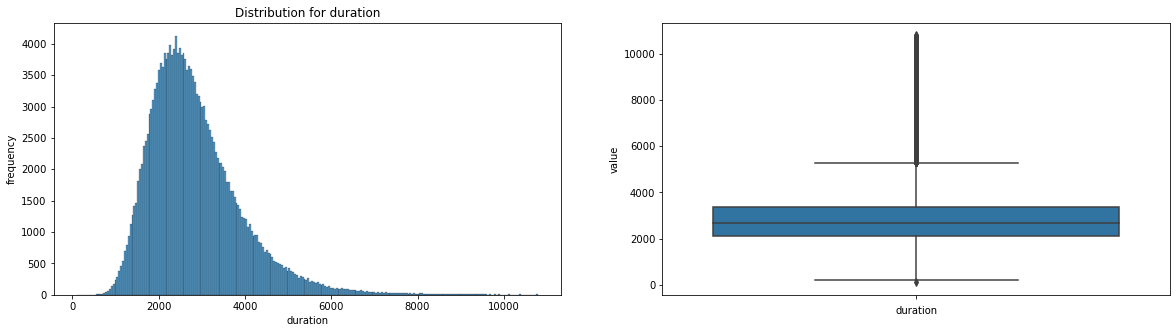

In [31]:
plot_distribution(df_train, "duration")

* After removing the outliers in the duration, the distribution looks like right-skewed normal

### Calculate the correlation between variables

In [32]:
df_sub = df_train[continuous_columns + ["month", "week", "dayofweek", "hour"]]
corr_matrix = df_sub.corr()
display(corr_matrix)

,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,duration,month,week,dayofweek,hour
subtotal,1.000000,0.126848,0.124044,0.128182,0.034554,0.220527,-0.006060,-0.009527,0.032301,-0.184819
total_onshift_dashers,0.126848,1.000000,0.972033,0.924268,0.042267,0.072392,-0.023541,-0.016004,0.085804,-0.374468
total_busy_dashers,0.124044,0.972033,1.000000,0.934635,0.040224,0.098729,-0.042614,-0.034585,0.077226,-0.359015
total_outstanding_orders,0.128182,0.924268,0.934635,1.000000,0.035672,0.187606,0.044555,0.040236,0.078539,-0.370202
estimated_store_to_consumer_driving_duration,0.034554,0.042267,0.040224,0.035672,1.000000,0.237541,0.011599,0.010117,0.008041,-0.023022
duration,0.220527,0.072392,0.098729,0.187606,0.237541,1.000000,0.064984,0.039742,0.001485,-0.171903
month,-0.006060,-0.023541,-0.042614,0.044555,0.011599,0.064984,1.000000,0.812943,-0.102068,-0.035413
week,-0.009527,-0.016004,-0.034585,0.040236,0.010117,0.039742,0.812943,1.000000,-0.338606,-0.060929
dayofweek,0.032301,0.085804,0.077226,0.078539,0.008041,0.001485,-0.102068,-0.338606,1.000000,0.019130
hour,-0.184819,-0.374468,-0.359015,-0.370202,-0.023022,-0.171903,-0.035413,-0.060929,0.019130,1.000000


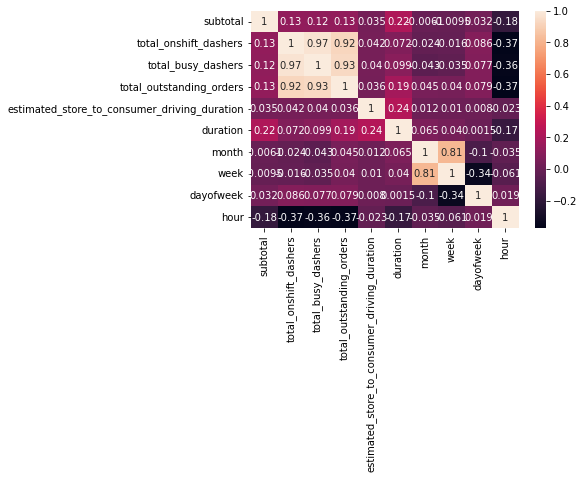

In [33]:
# plot correlation matrix
corr = sns.heatmap(corr_matrix, annot=True) 

### Find the relations

* Now I am going to check the duration distribution by market_id, month, week, dayofweek, hour

In [34]:
def plot_duration_distribution(df, granularity, **kwargs):
    df_sub = df_train.loc[:, [granularity, "duration"]]
    
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.histplot(data=df_sub, x="duration", hue=granularity, **kwargs)
    ax.set_xlabel("duration (in second)")
    plt.show()

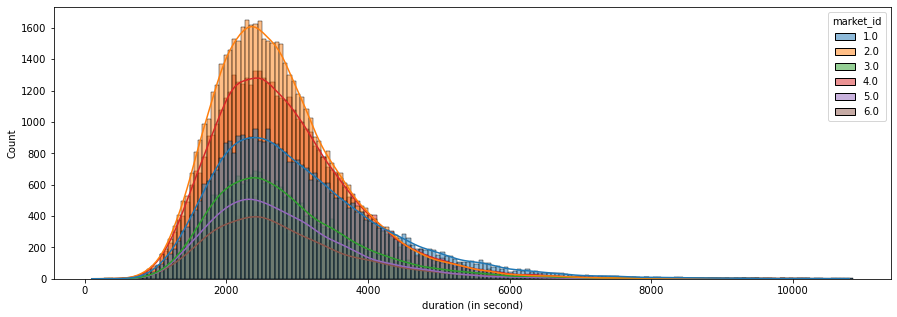

In [35]:
plot_duration_distribution(df_train, "market_id", binwidth=60, kde=True)

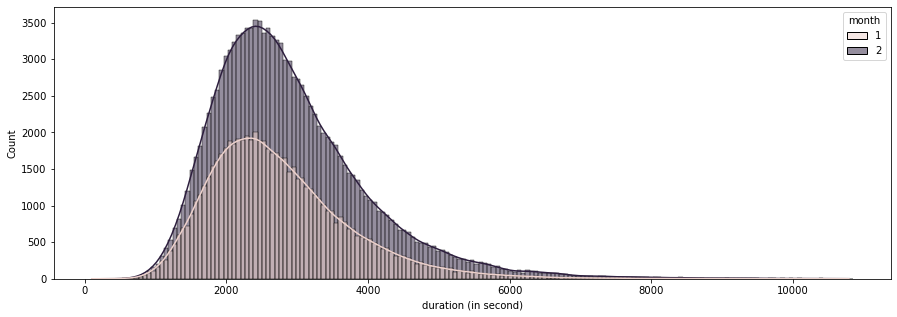

In [36]:
plot_duration_distribution(df_train, "month", binwidth=60, kde=True)

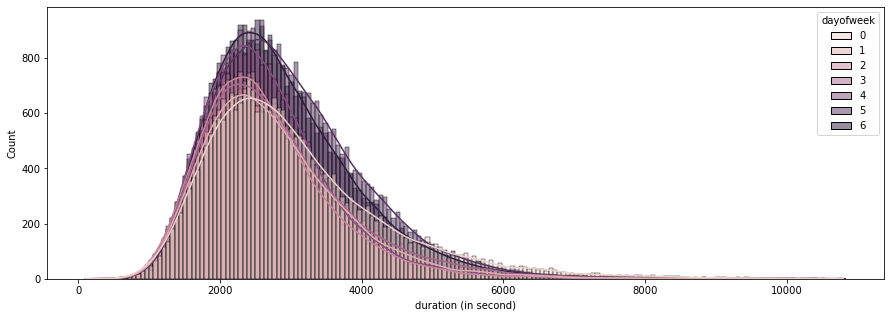

In [37]:
plot_duration_distribution(df_train, "dayofweek", binwidth=60, kde=True)

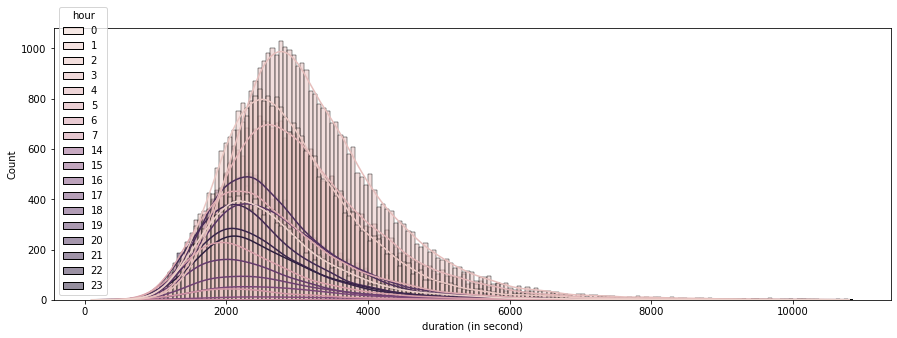

In [38]:
plot_duration_distribution(df_train, "hour", binwidth=60, kde=True)

I find
* different markets have similar duration distribution
* February take slightly longer time to delivery than the January
* Each day of a week has different duration distribution
* Each hour has very different duration distribution

Therefore, dayofweek and hour could have important impact in the duration forecat.

In [39]:
df_train.head()

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,duration,...,dt_month,dt_week,dt_dayofweek,dt_hour,sdt_market,sdt_store,sdt_month,sdt_week,sdt_dayofweek,sdt_hour
1,1.0,2015-02-06 22:16:03,2015-02-06 23:28:14,1807,825,3.0,3.0,3.0,615.0,4331.0,...,2916.692356,2959.284291,2684.771085,2526.855232,2159.853855,835.295525,1515.239942,1275.404993,970.574625,1130.291088
2,1.0,2015-02-06 22:46:07,2015-02-06 23:36:48,4302,1107,4.0,2.0,2.0,547.0,3041.0,...,2916.692356,2959.284291,2684.771085,2526.855232,2159.853855,673.849575,1515.239942,1275.404993,970.574625,1130.291088
3,1.0,2015-02-06 22:48:55,2015-02-06 23:22:05,495,3950,21.0,18.0,16.0,219.0,1990.0,...,2916.692356,2959.284291,2684.771085,2526.855232,2159.853855,1078.292916,1515.239942,1275.404993,970.574625,1130.291088
4,1.0,2015-02-06 22:09:36,2015-02-06 22:51:32,4531,2000,6.0,5.0,6.0,170.0,2516.0,...,2916.692356,2959.284291,2684.771085,2526.855232,2159.853855,706.199621,1515.239942,1275.404993,970.574625,1130.291088
5,1.0,2015-02-06 22:10:54,2015-02-06 22:44:31,6642,850,17.0,17.0,21.0,849.0,2017.0,...,2916.692356,2959.284291,2684.771085,2526.855232,2159.853855,946.720809,1515.239942,1275.404993,970.574625,1130.291088


### Check mean value in different category

In [40]:
col_names = [
    "market_id",
    "total_onshift_dashers",
    "total_busy_dashers",
    "total_outstanding_orders",
    "dayofweek",
    "hour",
    "duration"
]
df_sub = df_train.loc[:, col_names]

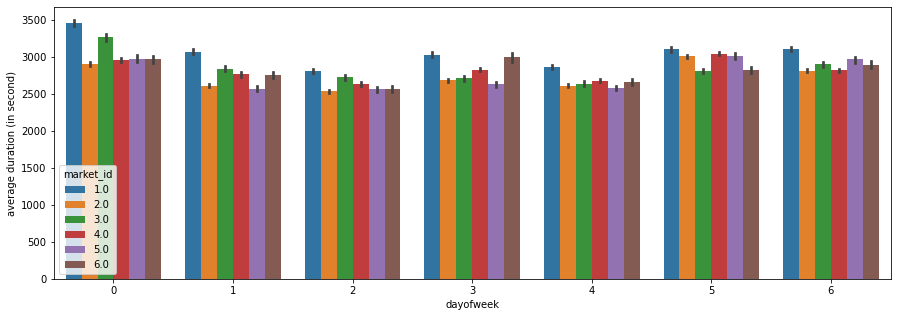

In [41]:
df_group = df_sub.groupby(["market_id", "dayofweek"])["duration"].mean().reset_index()

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df_sub, x="dayofweek", y="duration", hue="market_id")
ax.set_ylabel("average duration (in second)")
plt.show()

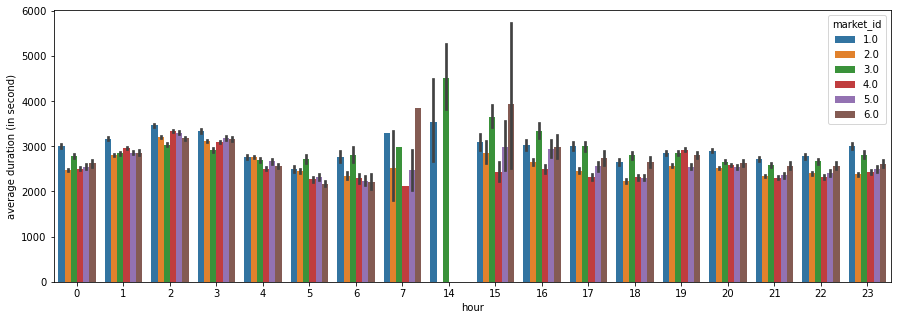

In [42]:
df_group = df_sub.groupby(["market_id", "hour"])["duration"].mean().reset_index()

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df_sub, x="hour", y="duration", hue="market_id")
ax.set_ylabel("average duration (in second)")
plt.show()

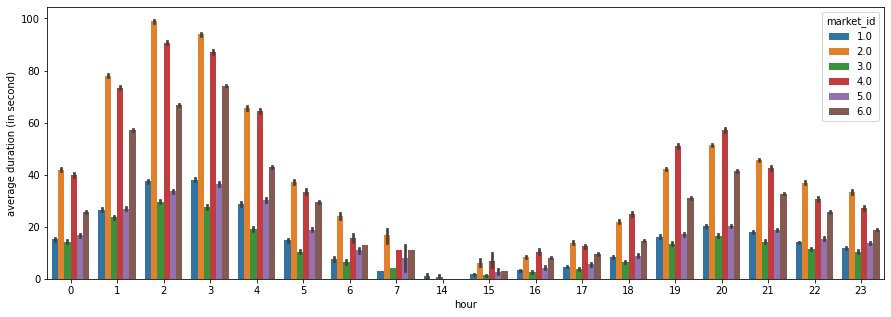

In [43]:
df_group = df_sub.groupby(["market_id", "hour"])["total_onshift_dashers"].mean().reset_index()

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df_sub, x="hour", y="total_onshift_dashers", hue="market_id")
ax.set_ylabel("average duration (in second)")
plt.show()

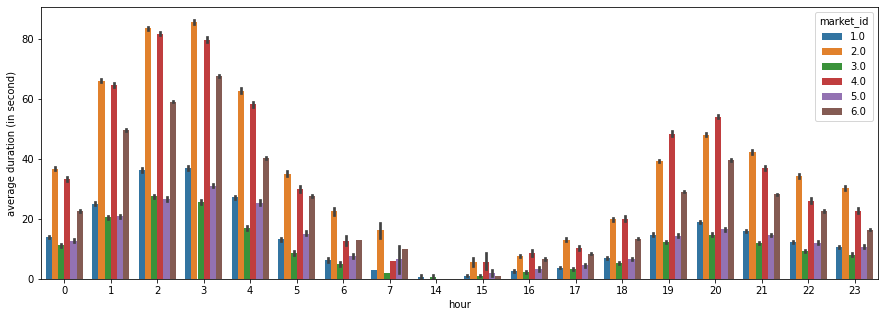

In [44]:
df_group = df_sub.groupby(["market_id", "hour"])["total_busy_dashers"].mean().reset_index()

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df_sub, x="hour", y="total_busy_dashers", hue="market_id")
ax.set_ylabel("average duration (in second)")
plt.show()

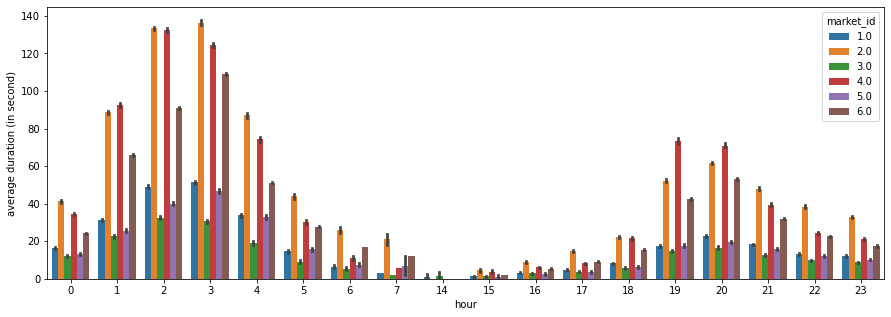

In [45]:
df_group = df_sub.groupby(["market_id", "hour"])["total_outstanding_orders"].mean().reset_index()

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df_sub, x="hour", y="total_outstanding_orders", hue="market_id")
ax.set_ylabel("average duration (in second)")
plt.show()

I find
* market 1 has longer duration for all days in a week
* markets 2, 4, 6 have more onshift drivers, more busy drivers, and more outstanding orders.
* hour 5 to 18 has less onshift drivers, less busy drivers, and less outstanding orders

### Find the top 10 store in each market


In [46]:
df_sub = df_train.loc[:, ["market_id", "store_id", "created_at"]]
df_group = (
    df_sub.groupby(["market_id", "store_id"])[["created_at"]]
    .count().reset_index()
    .rename(columns={"created_at":"count"})
    .sort_values(by=["market_id", "count"], ascending=False)
)



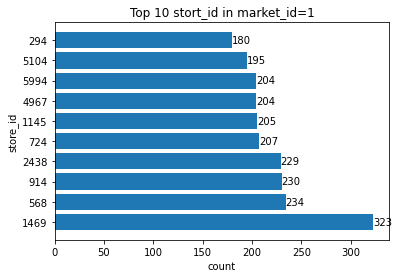

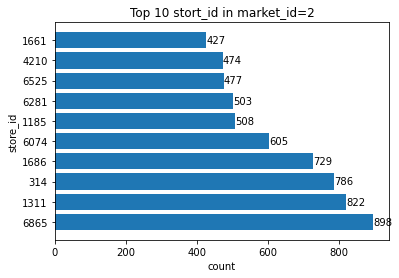

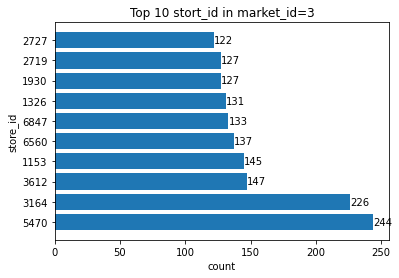

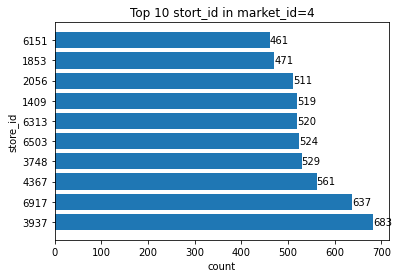

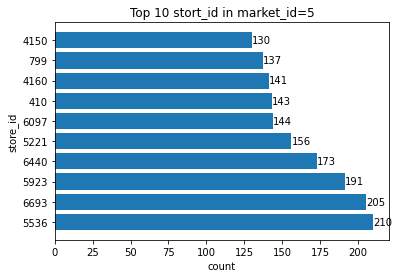

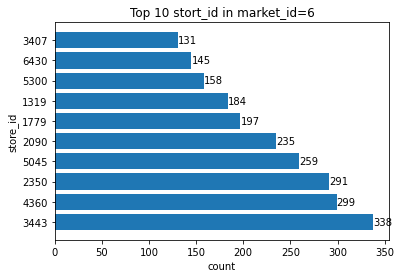

In [47]:
for mid in range(1, 7):
    df_data = df_group.loc[df_group["market_id"]==mid].head(10)

    
    fig, ax = plt.subplots()
    y_ticks = range(1, 11)
    y_ticklabels = df_data["store_id"]
    x_val = df_data["count"]
    bars = ax.barh(y_ticks, x_val)
    ax.bar_label(bars)
    
    ax.set_ylabel("store_id")
    ax.set_xlabel("count")
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticklabels)
    ax.set_title(f"Top 10 stort_id in market_id={mid}")

### Find the relation between `subtotal` and `duration`

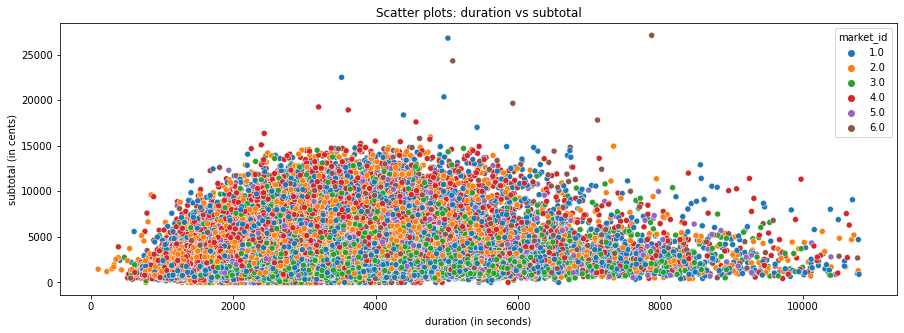

In [48]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(
    data=df_train,
    x="duration",
    y="subtotal",
    hue="market_id"
)
ax.set_xlabel("duration (in seconds)")
ax.set_ylabel("subtotal (in cents)")
ax.set_title("Scatter plots: duration vs subtotal")
plt.show()

* I cannot find the relation between `subtotal` and `duration`

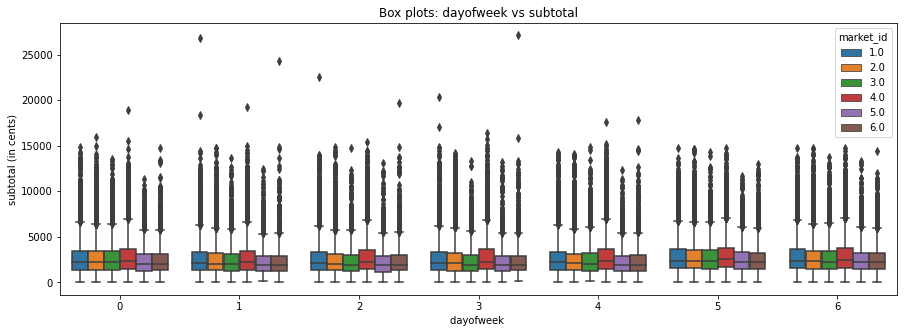

In [49]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(
    data=df_train,
    x="dayofweek",
    y="subtotal",
    hue="market_id"
)
ax.set_xlabel("dayofweek ")
ax.set_ylabel("subtotal (in cents)")
ax.set_title("Box plots: dayofweek vs subtotal")
plt.show()

* The box plot shows the subtotals are about the same range in different day of week and in different markets